# Part 1: Stitching pairs of images

In [8]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 

ModuleNotFoundError: No module named 'cv2'

In [16]:
from pathlib import Path
from skimage.io import imread as _imread
from skimage.color import rgb2gray


def imread(filename: str, as_gray: bool = False):
    """Read image data for this part."""
    path = Path("part1") / filename
    im = _imread(path)
    if as_gray and (im.ndim == 3):
        return rgb2gray(im)
    else:
        return im


In [25]:
im = imread("left.jpg", as_gray=True)
print(f"min(im)={np.min(im)}, max(im)={np.max(im)}")


min(im)=0.009569411764705882, max(im)=1.0


In [35]:
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.transform import pyramid_laplacian, resize
from scipy.ndimage import rank_filter


class SIFT:
    def __init__(self, downscale=1.2, n_scale=8, n_keypoints=500, harris_k=0.04):
        self.downscale = downscale
        self.n_scale = n_scale
        self.n_keypoints = n_keypoints
        self.harris_k = harris_k

        self.keypoints = None
        self.scales = None
        self.responses = None
        self.orientations = None
        self.descriptors = None

    def _blob_log(
        self, image, min_sigma=1, max_sigma=50, sigma_ratio=1.6, threshold=0.2
    ):
        if sigma_ratio <= 1:
            raise ValueError("sigma_ratio must be > 1.0")

        # k such that min_sigma*(sigma_ratio**k) > max_sigma
        k = int(np.mean(np.log(max_sigma / min_sigma) / np.log(sigma_ratio) + 1))
        # build sigmas
        sigma_list = np.array([min_sigma * (sigma_ratio ** i) for i in range(k + 1)])
        print(f"min(sigma)={sigma_list[0]}, max(sigma)={sigma_list[-1]}, n={k}")

        pyramid = pyramid_laplacian(
            image,
            max_layer=k + 1,
            downscale=sigma_ratio,
            sigma=min_sigma,
            order=1,
            mode="constant",
            cval=0,
            multichannel=False,
        )
        # skip 0th, this is the original image
        pyramid = next(pyramid)

        # multiply sigma**2 to provide scale invariance
        shape = image.shape
        scale_space = [-resize(layer, shape) * min_sigma ** 2 for layer in pyramid]
        scale_space = np.stack(scale_space, axis=-1)

        # non-maximal suppresion along each scale
        scale_space_nms = rank_filter(
            scale_space, -1, footprint=np.ones((3,) * (scale_space.ndim - 1) + (1,))
        )
        scale_space_nms = np.max(scale_space_nms, axis=-1)

        scale_space_mask = scale_space == scale_space_nms[..., np.newaxis]
        scale_space_mask &= scale_space > threshold

        print(scale_space_mask.shape)

        blob_index = np.where(scale_space_mask)
        blob_index = np.stack(blob_index).T
        # replace scale index with actual sigma
        blob_sigma = sigma_list[blob_index[:, -1]]
        blobs = np.hstack([blob_index[:, :-1], blob_sigma[:, np.newaxis]])

        print(blobs)

    def detect(self, image):
        """
        Detect keypoints in image.
        
        Args:
            image (2D array): Input image.
        """

        self._blob_log(image)

    def extract(self, image, keypoints):
        """
        Extract feature descriptors in image for given keypoints.
        
        Args:
            image (2D array): Input image.
            keypoints ((N, 2) array): Keypoint locations as (row, col).
        """


im = imread("left.jpg", as_gray=True)

detector = SIFT()
detector.detect(im)


min(sigma)=1.0, max(sigma)=68.71947673600003, n=9
(398, 800, 398)


IndexError: index 174 is out of bounds for axis 0 with size 10

[ True False  True  True  True  True  True  True  True False False False
 False False False False False  True  True  True False  True  True  True
 False  True False  True False  True False  True  True False False  True
 False False False  True  True False  True  True  True False False False
 False False False  True False False  True False False  True  True  True
 False False False False  True  True  True False  True  True  True False
  True False  True  True False False False False  True False  True False
 False False False  True  True False False False  True False False False
  True  True  True False False  True  True False False  True False False
 False  True False  True  True  True False False  True  True False False
 False False  True  True  True  True  True False False False  True False
  True False  True  True False  True False False False False  True  True
 False False  True  True  True  True  True False  True False  True  True
  True False  True  True  True  True  True  True Fa

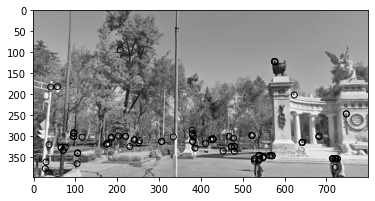

In [24]:
from skimage.feature import ORB

im = imread("left.jpg", as_gray=True)

detector = ORB(n_keypoints=100)
detector.detect_and_extract(im)

keypoints, descriptors = detector.keypoints, detector.descriptors
print(descriptors[0])
fig, ax = plt.subplots()
ax.imshow(im, cmap='gray')
ax.scatter(keypoints[:, 1], keypoints[:, 0], facecolors='none', edgecolors='k')


In [ ]:
# Provided code - nothing to change here

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)

In [6]:
# See assignment page for the instructions!